Epoch 1/20


c:\Users\pegie\repos\ids2017-anomaly-detection\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3654/3654 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.8573 - val_loss: 0.5555
Epoch 2/20
3654/3654 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.7349 - val_loss: 0.5554
Epoch 3/20
3654/3654 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.5552 - val_loss: 0.5553
Epoch 4/20
3654/3654 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.8019 - val_loss: 0.5553
Epoch 5/20
3654/3654 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.6622 - val_loss: 0.5544
Epoch 6/20
3654/3654 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.8462 - val_loss: 0.5544
Epoch 7/20
3654/3654 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 1.0749 - val_loss: 0.5543
Epoch 8/20
3654/3654 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.6543 - val_loss: 0.5535
Epoch 9/20
3654/3654 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.7614 - val_loss: 0.5535
Epoch 10/20
3654/3654 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.8788 - val_loss: 0.5535
Epoch 11/20
3654/3654 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.8479 - val_loss: 0.5535
Epoch 12/20
3654/3654 ━━━━━━━━━━━━━━━━━━━

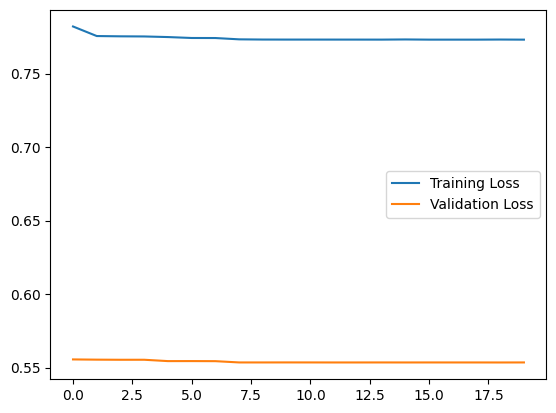

Train MSE: 0.7729382090323302
Test MSE: 0.5534774556083838


In [13]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import matplotlib.pyplot as plt

# Load the data
data = pd.read_parquet('IDS2017/Final/Combined.parquet')
y = data['Label']
# Binary classification
y = y.apply(lambda x: 0 if x != 'BENIGN' else 1)  # 1- benign, 0 - attack
X = data.drop('Label', axis=1)

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

input_dim = X_train.shape[1]
encoding_dim = 32  
hidden_dim = 64

# Build the autoencoder model
autoencoder = Sequential()
autoencoder.add(Dense(hidden_dim, activation='relu', input_shape=(input_dim,)))
autoencoder.add(Dropout(0.2))
autoencoder.add(Dense(encoding_dim, activation='relu'))
autoencoder.add(Dropout(0.2))
autoencoder.add(Dense(hidden_dim, activation='relu'))
autoencoder.add(Dense(input_dim, activation='sigmoid'))

# Compile the model
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = autoencoder.fit(X_train, X_train,
                          epochs=20,  # Increased epochs
                          batch_size=256,  # Adjusted batch size
                          shuffle=True,
                          validation_data=(X_test, X_test))

# Predictions
X_train_pred = autoencoder.predict(X_train)
X_test_pred = autoencoder.predict(X_test)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# Calculate and print MSE
train_mse = mean_squared_error(X_train, X_train_pred)
test_mse = mean_squared_error(X_test, X_test_pred)

print(f"Train MSE: {train_mse}")
print(f"Test MSE: {test_mse}")


array([0.18192472, 0.14345823, 0.10252703, ..., 0.41474484, 0.1215147 ,
       0.19118743])

array([0.21455597, 0.19078025, 0.18864494, ..., 0.70506794, 0.13539488,
       0.11744744])

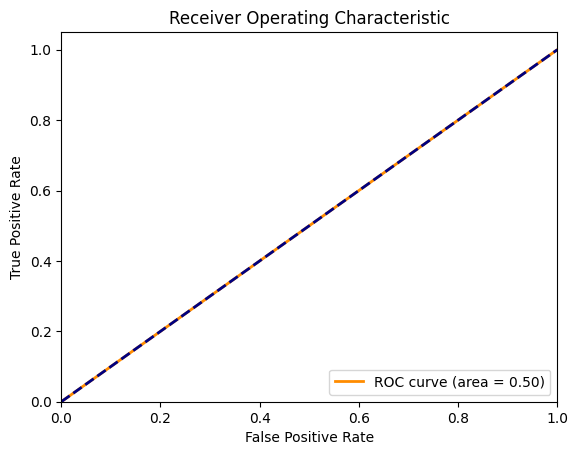

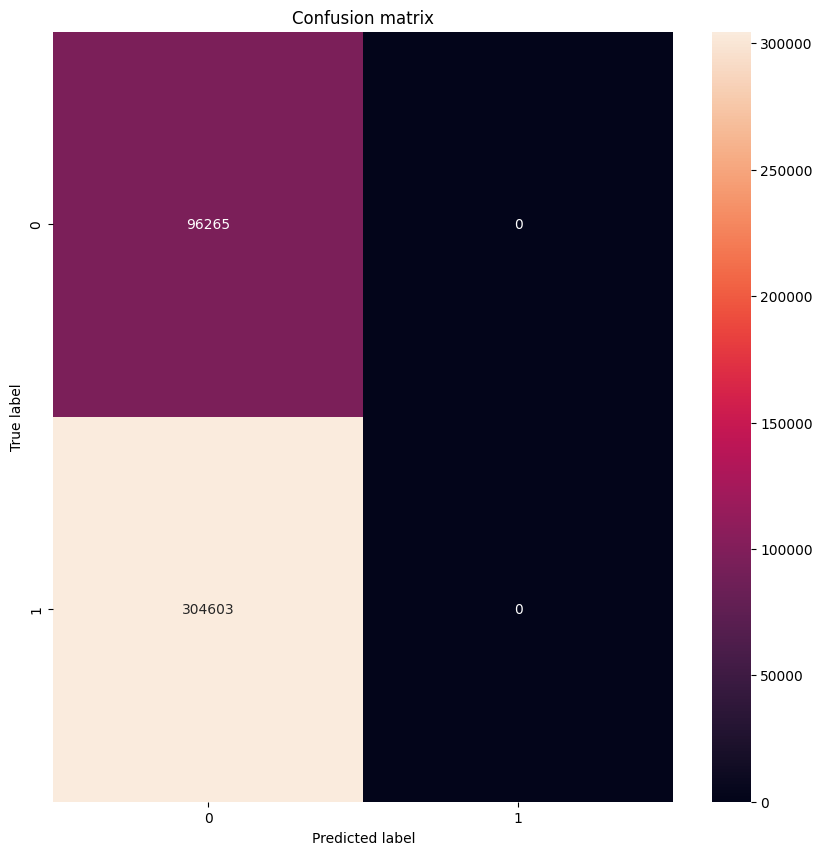

In [14]:
from sklearn.metrics import roc_curve, auc, confusion_matrix
import seaborn as sns

# Calculate reconstruction error
mse_train = np.mean(np.power(X_train - X_train_pred, 2), axis=1)
mse_test = np.mean(np.power(X_test - X_test_pred, 2), axis=1)
display(mse_train)
display(mse_test)
# Choose a threshold
threshold = np.max(mse_train)

# Classify as normal or anomaly
y_train_pred = (mse_train > threshold).astype(int)
y_test_pred = (mse_test > threshold).astype(int)

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_test, y_test_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()